In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
os.chdir('..')

In [5]:
import requests
from Bio import SeqIO
from mofiwo.connector.ensembl import read_ensembl

In [6]:
ret_esm = read_ensembl('ENSMUST00000037811', req_param={'type':'cds'})

In [6]:
from mofiwo.utility.rna_handler import load_rna_fasta_zipfile

In [9]:
fasta_cds_zipfile = r'E:\workspace\rnamotif\samples\s1_cds.zip'
fasta_cdna_zipfile = r'E:\workspace\rnamotif\samples\s1_cdna.zip'
#fasta_zipfile = r'C:/Users/byeun/Downloads/s1_cds.zip'

In [10]:
dic_cds = load_rna_fasta_zipfile(fasta_cds_zipfile)
dic_cdna = load_rna_fasta_zipfile(fasta_cdna_zipfile)

In [11]:
from mofiwo.utility.rna_handler import generate_3utr_from_cdna_cds

In [ ]:
dic_utr3 = generate_3utr_from_cdna_cds(dic_cdna, dic_cds)

In [16]:
import pandas as pd

In [19]:
df_s1 = pd.read_excel(r'E:/workspace/rnamotif/samples/aan2399_table_S1.xlsx')

In [20]:
df_s1.head()

,target_id,ens_gene,ext_gene,b,pval,qval,mean_obs
0,ENSMUST00000087033,ENSMUSG00000067149,Jchain,-7.288847,1.062304e-56,1.052212e-52,3.310219
1,ENSMUST00000178282,ENSMUSG00000095079,Igha,-7.194008,4.649536e-56,2.302683e-52,4.962844
2,ENSMUST00000029805,ENSMUSG00000028158,Mttp,1.606198,8.478666e-50,2.799373e-46,6.664327
3,ENSMUST00000103410,ENSMUSG00000076609,Igkc,-6.531983,4.362243e-46,1.080200e-42,5.397054
4,ENSMUST00000073490,ENSMUSG00000026354,Lct,1.863466,7.839152e-40,1.552936e-36,5.571108


In [33]:
lst_apical = list(df_s1[df_s1.apply(lambda x: x.qval < 0.2 and x.b > 0 and x.mean_obs > 3.539 , axis=1)].target_id)
dic_apical = {x:dic_utr3[x] for x in lst_apical if x in dic_utr3.keys()}
dic_apical = {k:str(v.seq) for k,v in dic_apical.items()}

In [142]:
def generate_target_group(df_target, dic_utr3, qval_limit = 0.2, is_apical=True, mean_obs_limit=3.539):
    if is_apical:
        df_target = df_target[df_target.b > 0]
    else:
        df_target = df_target[df_target.b < 0]
    lst_apical = list(df_target[df_target.apply(lambda x: 
                                                x.qval < qval_limit and 
                                                x.mean_obs > mean_obs_limit , axis=1)].target_id)
    
    return {x:str(dic_utr3[x].seq) for x in lst_apical if x in dic_utr3.keys()}

In [145]:
dic_apical = generate_target_group(df_s1, dic_utr3)
len(dic_apical)

379

In [146]:
dic_basal = generate_target_group(df_s1, dic_utr3, is_apical=False)
len(dic_basal)

87

In [151]:
import re
import pickle
import itertools
import pandas as pd
import numpy as np

In [176]:
def generate_bp_count(bp_grp, dic_seq):
    bp_all = itertools.product(['A','T','C','G'], repeat=bp_grp)
    bp_all = [''.join(x) for x in bp_all]
    bp_cnt = {bp:0 for bp in bp_all}
    for key, seq in dic_seq.items():
        for bp in bp_all:
            num_bp = len(re.findall(bp, seq)) 
            if num_bp > 0:
                bp_cnt[bp] += num_bp
    return pd.DataFrame.from_dict(bp_cnt, orient='index', columns=[f'bp_{bp_grp}'])

In [132]:
res_bp = dict()
for i in [3,4,5,6,7,8,9]:
    res_bp[i] = generate_bp_count(i)
pickle.dump({'seq':dic_apical, 'bp_grp':res_bp}, open(r'E:\workspace\rnamotif\samples\apical_bp_3_9.pickle','wb'))

In [177]:
bp_grp_basal = {8: generate_bp_count(8,dic_basal)}

In [179]:
df_temp = bp_grp_basal[8].sort_values('bp_8', ascending=False)
df_temp['basal_rank'] = np.arange(len(df_temp))

In [180]:
df_temp2 = res_bp[8].sort_values('bp_8',ascending=False)
df_temp2['apical_rank'] = np.arange(len(df_temp2))

In [182]:
df_bp8_rank = pd.merge(df_temp['basal_rank'], df_temp2['apical_rank'],left_index=True,right_index=True)

In [188]:
df_bp8_rank.head(20)

,basal_rank,apical_rank
AAAAAAAA,0,3
TTTTTTTT,1,0
AGAAAGAA,2,80
AAAGAAAG,3,152
CACACACA,4,7
AAGAAAGA,5,161
GAAAGAAA,6,101
GAGAGAGA,7,292
AGAGAGAG,8,271
TTTGTTTT,9,1


In [187]:
df_bp8_rank.sort_values('apical_rank').head(10)

,basal_rank,apical_rank
TTTTTTTT,1,0
TTTGTTTT,9,1
TTTTGTTT,28,2
AAAAAAAA,0,3
TTTTTTAA,10,4
TTTTTAAA,19,5
TTTTAAAA,30,6
CACACACA,4,7
ATTTTTTT,21,8
TTTTTTTA,13,9


<AxesSubplot:>

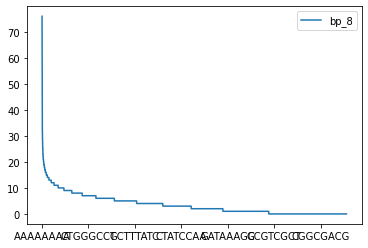

In [184]:
bp_grp_basal[8].sort_values('bp_8',ascending=False).plot()

<AxesSubplot:>

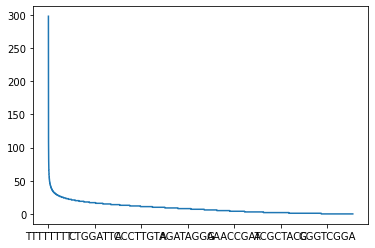

In [186]:
df_temp2['bp_8'].plot()